In [1]:
import torch
import pandas as pd
df = pd.read_json('/home/userroot/dev/zms/datasets/2024_04_24_index_300_keynotes.jsonl', lines=True)
t = torch.tensor(df['embeddings']).reshape(df.shape[0],1, -1).squeeze()
df_embeddings = pd.DataFrame(t)
df_embeddings.insert(0, 'date', df['date'])
df_embeddings.insert(1, 'code', df['code'])

#获得股票代码对应的唯一值token编码
code_uniq = df_embeddings['code'].unique()

In [2]:

dict_arr = {value: index for index, value in enumerate(code_uniq)}
print(dict_arr)

{'sz300750': 0, 'sh600519': 1, 'sh601318': 2, 'sh600036': 3, 'sz000333': 4, 'sz000858': 5, 'sh600900': 6, 'sh601899': 7, 'sh601166': 8, 'sh600276': 9, 'sh600030': 10, 'sz002594': 11, 'sh601398': 12, 'sz000651': 13, 'sh600887': 14, 'sh601328': 15, 'sz300059': 16, 'sz300760': 17, 'sz000725': 18, 'sh600309': 19, 'sz002475': 20, 'sh600919': 21, 'sz000568': 22, 'sh601288': 23, 'sh601088': 24, 'sz300124': 25, 'sh601816': 26, 'sh600809': 27, 'sz002415': 28, 'sh601012': 29, 'sz002714': 30, 'sh600028': 31}


In [63]:
import tushare as ts
import numpy as np
pro = ts.pro_api()
for i, g in df_embeddings.groupby('code'):
    print(g['code'].iloc[0])
    code = g['code'].iloc[0]
    part1 = code[:2]
    part2 = code[2:]

    idx = dict_arr[code]
    sorted_g = g.sort_values(by='date')
    #sorted_g.insert(2,'idx',idx)
    df_day = sorted_g['date'].apply(lambda x: x.strftime('%Y%m%d'))
    df_hour = sorted_g['date'].apply(lambda x: x.strftime('%H'))

    sorted_g.insert(1, 'day', df_day) 
    sorted_g.insert(2,'hour', df_hour)

    columns_to_sum = sorted_g.columns[4:]
    grouped_sum = sorted_g.groupby(['day', 'hour'])[columns_to_sum].sum().reset_index()

    # 生成0-24的整数序列
    numbers = list(range(0, 24))
    # 添加前导零，使序列中的每个元素都为两位数
    formatted_numbers = ['{:02}'.format(num) for num in numbers]
    hour_df = pd.DataFrame({'hour' :formatted_numbers})
    hour_df['tmp'] = 1

    day_uniq = pd.DataFrame(grouped_sum['day'].unique(), columns=['day'])
    day_uniq['tmp'] = 1
    day_hour_uniq = pd.merge(day_uniq, hour_df, on='tmp', how='outer')
    day_hour_uniq.pop('tmp')


    # h_group = pd.merge(day_hour_uniq, grouped_sum, on=['day','hour'], how='left')
    # h_group.pop('tmp')

    new_group = pd.merge(day_hour_uniq, grouped_sum, on=['day','hour'], how='left')
    new_group.ffill(inplace=True)
    new_group.bfill(inplace=True)

    min_date = (df_day.min())
    max_date = (df_day.max())

    # 获取最近前后一天的交易日，如果本身是交易日则返回本身
    t_days = pro.trade_cal(exchange='SSE', end_date=min_date)
    last_trade_day = t_days[t_days['is_open']==1].iloc[0]['cal_date']
    t_days = pro.trade_cal(exchange='SSE', start_date=max_date)
    next_trade_day = t_days[t_days['is_open']==1].iloc[-1]['cal_date']
    
    df_kline = pro.daily(ts_code=part2+'.'+part1, start_date=last_trade_day, end_date=next_trade_day)
    #df_kline.to_csv(f'./index_300/{code}_kline.csv',index=False)
    print(f'trade day from {min_date} to {max_date} count: {len(df_kline)}')
    df_kline.sort_values(by='trade_date', inplace=True)
    df_kline['idx'] = idx

    df_kline['tmp'] = 1
    df_kline = pd.merge(df_kline, hour_df, on='tmp', how='outer')
    df_kline.pop('tmp')

    df_kline.rename(columns={'trade_date':'day'}, inplace=True)

    merged_out = pd.merge(new_group, df_kline, on=['day','hour'], how='outer')
    
    merged_out.sort_values(by=['day', 'hour'], inplace=True)
    merged_out.reset_index(inplace=True)
    merged_out.ffill(inplace=True)
    merged_out.rename(columns={'day':'date'}, inplace=True)
    merged_out.dropna(inplace=True)
    merged_out.pop('idx')
    merged_out.insert(1,'idx', idx)
    merged_out.pop('index')
    merged_out.pop('ts_code')

    merged_out.to_csv(f'./index_300_align_hour/{code}.csv',index=False)

    #break

sh600028


trade day from 20231017 to 20240330 count: 113
sh600030
trade day from 20231008 to 20240406 count: 123
sh600036
trade day from 20231028 to 20240406 count: 108
sh600276
trade day from 20231018 to 20240404 count: 115
sh600309
trade day from 20230819 to 20240407 count: 152
sh600519
trade day from 20231022 to 20240406 count: 113
sh600809
trade day from 20231017 to 20240405 count: 116
sh600887
trade day from 20231031 to 20240405 count: 106
sh600900
trade day from 20230706 to 20240403 count: 182
sh600919
trade day from 20230923 to 20240407 count: 127
sh601012
trade day from 20231031 to 20240407 count: 106
sh601088
trade day from 20230914 to 20240407 count: 133
sh601166
trade day from 20231031 to 20240404 count: 106
sh601288
trade day from 20231013 to 20240407 count: 118
sh601318
trade day from 20231028 to 20240405 count: 108
sh601328
trade day from 20231028 to 20240407 count: 108
sh601398
trade day from 20231008 to 20240407 count: 123
sh601816
trade day from 20220919 to 20240407 count: 374
s

In [62]:
merged_out

,idx,date,hour,0,1,2,3,4,5,6,...,ts_code,open,high,low,close,pre_close,change,pct_chg,vol,amount
0,17,20231214,00,0.036098,-0.203368,0.185273,0.142686,0.106154,0.010710,0.093444,...,300760.SZ,299.88,301.0,293.88,295.00,297.89,-2.89,-0.9702,24728.34,731949.593
1,17,20231214,01,0.036098,-0.203368,0.185273,0.142686,0.106154,0.010710,0.093444,...,300760.SZ,299.88,301.0,293.88,295.00,297.89,-2.89,-0.9702,24728.34,731949.593
2,17,20231214,02,0.036098,-0.203368,0.185273,0.142686,0.106154,0.010710,0.093444,...,300760.SZ,299.88,301.0,293.88,295.00,297.89,-2.89,-0.9702,24728.34,731949.593
3,17,20231214,03,0.036098,-0.203368,0.185273,0.142686,0.106154,0.010710,0.093444,...,300760.SZ,299.88,301.0,293.88,295.00,297.89,-2.89,-0.9702,24728.34,731949.593
4,17,20231214,04,0.036098,-0.203368,0.185273,0.142686,0.106154,0.010710,0.093444,...,300760.SZ,299.88,301.0,293.88,295.00,297.89,-2.89,-0.9702,24728.34,731949.593
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2443,17,20240408,19,-0.019121,-0.120201,0.006723,0.033524,0.079076,0.060734,0.069882,...,300760.SZ,281.89,282.0,276.00,276.25,281.32,-5.07,-1.8022,29036.25,805151.858
2444,17,20240408,20,-0.019121,-0.120201,0.006723,0.033524,0.079076,0.060734,0.069882,...,300760.SZ,281.89,282.0,276.00,276.25,281.32,-5.07,-1.8022,29036.25,805151.858
2445,17,20240408,21,-0.019121,-0.120201,0.006723,0.033524,0.079076,0.060734,0.069882,...,300760.SZ,281.89,282.0,276.00,276.25,281.32,-5.07,-1.8022,29036.25,805151.858
2446,17,20240408,22,-0.019121,-0.120201,0.006723,0.033524,0.079076,0.060734,0.069882,...,300760.SZ,281.89,282.0,276.00,276.25,281.32,-5.07,-1.8022,29036.25,805151.858


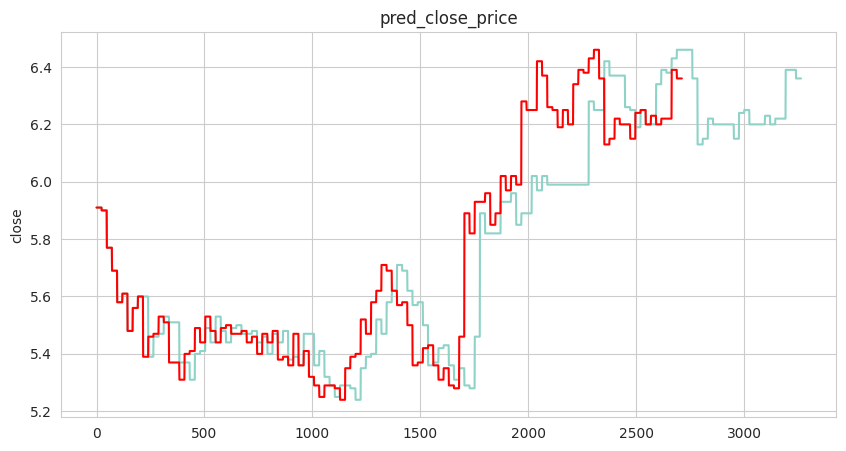

In [54]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
plt.figure(figsize=(10, 5))
sns.lineplot(data=merged_out['close'])
sns.lineplot(data=df_kline['close'],color='red')
# Adding title
plt.title('pred_close_price')

# Display the plot
plt.show()

In [26]:
merged_out

,date,hour,0,1,2,3,4,5,6,7,...,open,high,low,close,pre_close,change,pct_chg,vol,amount,idx
0,20231017,00,0.017436,-0.037303,-0.001553,0.023647,0.004944,0.062275,0.039161,0.083271,...,5.86,5.92,5.82,5.91,5.86,0.05,0.8532,982429.17,577921.115,31.0
1,20231017,01,0.017436,-0.037303,-0.001553,0.023647,0.004944,0.062275,0.039161,0.083271,...,5.86,5.92,5.82,5.91,5.86,0.05,0.8532,982429.17,577921.115,31.0
2,20231017,02,0.017436,-0.037303,-0.001553,0.023647,0.004944,0.062275,0.039161,0.083271,...,5.86,5.92,5.82,5.91,5.86,0.05,0.8532,982429.17,577921.115,31.0
3,20231017,03,0.017436,-0.037303,-0.001553,0.023647,0.004944,0.062275,0.039161,0.083271,...,5.86,5.92,5.82,5.91,5.86,0.05,0.8532,982429.17,577921.115,31.0
4,20231017,04,0.017436,-0.037303,-0.001553,0.023647,0.004944,0.062275,0.039161,0.083271,...,5.86,5.92,5.82,5.91,5.86,0.05,0.8532,982429.17,577921.115,31.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3259,20240401,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.39,6.40,6.29,6.36,6.39,-0.03,-0.4695,1265608.18,803452.484,31.0
3260,20240401,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.39,6.40,6.29,6.36,6.39,-0.03,-0.4695,1265608.18,803452.484,31.0
3261,20240401,21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.39,6.40,6.29,6.36,6.39,-0.03,-0.4695,1265608.18,803452.484,31.0
3262,20240401,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.39,6.40,6.29,6.36,6.39,-0.03,-0.4695,1265608.18,803452.484,31.0
